In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import gpytorch
import numpy as np
np.random.seed(80317)

In [2]:
df = pd.read_csv("simulated_processes.csv", index_col=0)

In [3]:
df

,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,y,process
0,22.110806,7.985831,48.960063,30.949504,14.911173,0.020440,18.754271,0.299052,13.579679,22.932271,11.218304,1
1,22.184670,7.989082,49.052957,30.930278,14.944083,0.029448,18.795390,0.305343,13.627254,22.952239,11.359190,1
2,22.259824,7.963708,49.148921,30.990834,15.006562,0.134376,18.876023,0.298495,13.626428,22.941168,11.348499,1
3,22.366680,7.995042,49.224236,30.976321,15.053245,0.031813,18.951105,0.263234,13.630308,22.894429,11.529785,1
4,22.403548,7.998855,49.310663,30.948270,15.126654,0.076781,19.015041,0.269125,13.687215,22.941736,11.511871,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1498,52.928148,8.012745,84.026264,30.916918,16.528789,0.050349,37.845667,0.284835,17.290115,22.907947,-947.288145,3
1499,52.977935,7.986611,84.122081,30.914668,16.539813,0.031815,37.867662,0.281221,17.300436,22.934116,-947.859789,3
1500,53.033974,8.003008,84.194332,30.999855,16.557315,0.021879,37.908384,0.291408,17.297794,22.963343,-948.888099,3
1501,53.121183,7.992165,84.265951,30.984256,16.543489,0.070324,37.887326,0.301864,17.327665,22.945969,-949.643749,3


In [4]:
# 2. For each process, split into 80/20 by time‐order
from sklearn.discriminant_analysis import StandardScaler


train_dfs = []
test_dfs  = []

for proc_id, g in df.groupby("process", sort=False):
    # g is already in time order if your CSV is grouped by process & time
    n       = len(g)
    cutoff  = int(n * 0.8)          # 80% point, e.g. int(501*0.8)=400
    train_dfs.append(g.iloc[:cutoff])
    test_dfs.append( g.iloc[cutoff:] )

train_df = pd.concat(train_dfs, ignore_index=True)
test_df  = pd.concat(test_dfs,  ignore_index=True)
feature_cols = [f"v{i}" for i in range(1,11)]
task_col = ["process"]
scaler_X = StandardScaler().fit(train_df[feature_cols])
train_df[feature_cols] = scaler_X.transform(train_df[feature_cols])
test_df[feature_cols]  = scaler_X.transform(test_df[feature_cols])

        # likewise for y:
#y_scaler = StandardScaler().fit(train_df[["y"]])
#train_df["y"] = y_scaler.transform(train_df[["y"]])
#test_df["y"]  = y_scaler.transform(test_df[["y"]])

# 3. Pull out features, targets, and zero‐based task index

def df_to_tensors(ddf, continuous, task):
    X = torch.from_numpy(ddf[continuous].values).float()      # shape (n,10)
    y = torch.from_numpy(ddf["y"].values).float()              # shape (n,)
    task = (ddf[task].astype(int) - 1).values             # 0,1,2
    t = torch.from_numpy(task).long()                          # shape (n,)
    return X, y, t

X_train, y_train, task_train = df_to_tensors(train_df, feature_cols, task_col)
#X_test,  y_test,  task_test  = df_to_tensors(test_df, feature_cols, task_col)



In [5]:
class MultiTaskGP(gpytorch.models.ExactGP):
    def __init__(self, train_inputs, train_targets, likelihood):
        super(MultiTaskGP, self).__init__(train_inputs, train_targets, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        ## here we will build the covariance for the model
        self.covar_rq = gpytorch.kernels.AdditiveKernel(gpytorch.kernels.RQKernel(ard_num_dims = 5, active_dims = [0,2,4,6,8]),gpytorch.kernels.LinearKernel(ard_num_dims = 5, active_dims = [0,2,4,6,8]))
        self.covar_rbf = gpytorch.kernels.RBFKernel(ard_num_dims = 5, active_dims = [1,3,5,7,9]) 
        self.composite = gpytorch.kernels.ProductKernel(self.covar_rq, self.covar_rbf)
        self.task_covar = gpytorch.kernels.IndexKernel(num_tasks=3, rank=1)

    def forward(self, x, i):
        mean_x = self.mean_module(x)
        covar_x = self.composite(x)
        covar_task = self.task_covar(i)
        covar = (covar_x).mul(covar_task)
        return  gpytorch.distributions.MultivariateNormal(mean_x, covar)

In [6]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()

In [7]:
# Here we have two iterms that we're passing in as train_inputs
model = MultiTaskGP((X_train, task_train), y_train, likelihood)

In [8]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iterations = 2 if smoke_test else 200


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.4)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
with gpytorch.settings.max_cg_iterations(10000),gpytorch.settings.cg_tolerance(1.0), gpytorch.settings.cholesky_jitter(1e-2), gpytorch.settings.fast_pred_var(False):
    for i in range(training_iterations):
        optimizer.zero_grad()
        output = model(X_train, task_train)
        loss = -mll(output, y_train)
        loss.backward()
        print('Iter %d/100 - Loss: %.3f' % (i + 1, loss.item()))
        optimizer.step()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/linear_operator/utils/interpolation.py:71: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:656.)
  summing_matrix = cls(summing_matrix_indices, summing_matrix_values, size)


Iter 1/100 - Loss: 12439.137
Iter 2/100 - Loss: 3088.141
Iter 3/100 - Loss: 1074.991
Iter 4/100 - Loss: 501.457
Iter 5/100 - Loss: 278.235
Iter 6/100 - Loss: 176.554
Iter 7/100 - Loss: 124.419
Iter 8/100 - Loss: 93.764
Iter 9/100 - Loss: 74.916
Iter 10/100 - Loss: 61.279
Iter 11/100 - Loss: 52.195
Iter 12/100 - Loss: 44.820
Iter 13/100 - Loss: 39.871
Iter 14/100 - Loss: 36.020
Iter 15/100 - Loss: 32.791
Iter 16/100 - Loss: 30.399
Iter 17/100 - Loss: 28.072
Iter 18/100 - Loss: 26.327
Iter 19/100 - Loss: 24.938
Iter 20/100 - Loss: 23.563
Iter 21/100 - Loss: 22.546
Iter 22/100 - Loss: 21.944
Iter 23/100 - Loss: 20.942
Iter 24/100 - Loss: 20.151
Iter 25/100 - Loss: 19.623
Iter 26/100 - Loss: 19.185
Iter 27/100 - Loss: 18.767
Iter 28/100 - Loss: 18.229
Iter 29/100 - Loss: 18.006
Iter 30/100 - Loss: 17.520
Iter 31/100 - Loss: 17.081
Iter 32/100 - Loss: 17.106
Iter 33/100 - Loss: 16.773
Iter 34/100 - Loss: 16.548
Iter 35/100 - Loss: 16.046
Iter 36/100 - Loss: 15.880
Iter 37/100 - Loss: 16.229

X_test, y_test for process 1


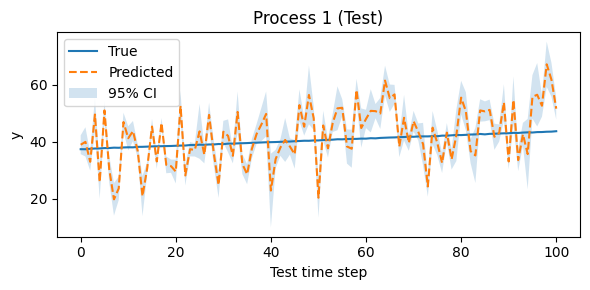

tensor(90.1747)
X_test, y_test for process 2


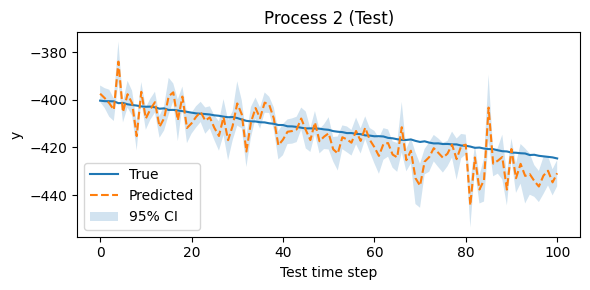

tensor(55.0048)
X_test, y_test for process 3


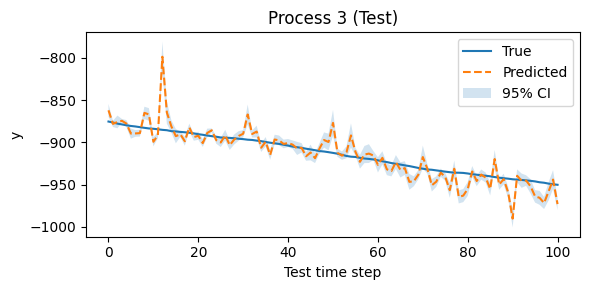

tensor(228.0679)


In [9]:
mse_list = []
mean_width = []
model.eval()
likelihood.eval()
for i in range(1,4):
    ## created the data for the evaluation
    print(f"X_test, y_test for process {i}")
    X_test = torch.tensor(test_df.loc[test_df["process"]==i].drop(columns=["y", "process"]).values, dtype=torch.float)
    y_test = torch.tensor(test_df["y"].loc[test_df["process"]==i].values, dtype=torch.float)
    ids = torch.full((X_test.shape[0],1), fill_value=i-1, dtype=torch.long)
    
    with torch.no_grad(), gpytorch.settings.max_cg_iterations(10000),gpytorch.settings.cg_tolerance(5.0), gpytorch.settings.cholesky_jitter(1e-2), gpytorch.settings.fast_pred_var(False):

                # f_preds is the posterior over the latent function f(x)
        f_pred = model(X_test, ids)  

                # y_pred is the posterior over the *observations* y*, i.e. includes noise
        y_pred = likelihood(f_pred)   

        lower, upper = f_pred.confidence_region() 
    y_true_np     = y_test.numpy()
    y_pred_np = y_pred.mean.numpy()
    n_pt = len(y_true_np)
    t_ix = np.arange(n_pt)
    plt.figure(figsize=(6,3))
    plt.plot(t_ix, y_true_np, label="True")
    plt.plot(t_ix, y_pred.mean.numpy(), '--', label="Predicted")
    plt.fill_between(t_ix, upper.numpy(), lower.numpy(), alpha=0.2,
                     label="95% CI")
    plt.title(f"Process {i} (Test)")
    plt.xlabel("Test time step")
    plt.ylabel("y")
    plt.legend()
    plt.tight_layout()

    plt.show()
    print(gpytorch.metrics.mean_squared_error(y_pred, y_test))

In [ ]:
y_pred.mean

In [ ]:
y_test

In [ ]:
test_id = torch.full((101,), 0, dtype=torch.float64)

In [ ]:
# turn everything into numpy
y_true_np     = y_test.numpy()
y_pred_np = y_pred.mean.numpy()


In [ ]:


# 3. Plot True vs Pred with 95% CI shading
# # ------------------------------------------
# for task_id in range(3):
#     mask = (task_test_np.squeeze() == task_id)
#     y_t  = y_true_np[mask]
#     y_p  = pred_means[task_id][mask]
#     lwr  = pred_lowers[task_id][mask]
#     upr  = pred_uppers[task_id][mask]
#     n_pt = len(y_t)
#     t_ix = np.arange(n_pt)
n_pt = len(y_true_np)
t_ix = np.arange(n_pt)
plt.figure(figsize=(6,3))
plt.plot(t_ix, y_true_np, label="True")
plt.plot(t_ix, y_pred.mean.numpy(), '--', label="Predicted")
plt.fill_between(t_ix, upper.numpy(), lower.numpy(), alpha=0.2,
                     label="95% CI")
plt.title(f"Process {proc_id} (Test)")
plt.xlabel("Test time step")
plt.ylabel("y")
plt.legend()
plt.tight_layout()

plt.show()

In [ ]:
test = np.array(np.float64(observed_pred_y1.mean))


In [ ]:
y1 = test_df["y"].loc[test_df["process"]==1]

In [ ]:
y_p  = pred_means[0][0:101]

In [ ]:
y_p.shape

In [ ]:
from sklearn.metrics import mean_squared_error

mean_squared_error(y_p, y1)

In [ ]:
torch.mean(upper3-lower3)

In [ ]:
upper2[101:202]

In [ ]:
lower2[101:202]

In [ ]:
torch.mean(upper2[101:202]-lower2[101:202])